## **1. Import Libraries**

In [ ]:
from google.colab import files
import pandas as pd
import json
import torch
import re
import nltk
import matplotlib.pyplot as plt
from google.colab import files
import pandas as pd
import io
import torch

**1.1 Load Pre-Trained Models**

Model 1 : RoBERTa

In [ ]:
# Load the pretrained model and tokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_name = "cardiffnlp/twitter-roberta-base-irony"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/705 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Model 2 : T5-base Fine-Tuned for Sarcasm Detection

In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

# Load the T5-base fine-tuned model and tokenizer
t5_model_name = "mrm8488/t5-base-finetuned-sarcasm-twitter"
t5_tokenizer = AutoTokenizer.from_pretrained(t5_model_name)
t5_model = AutoModelForSequenceClassification.from_pretrained(t5_model_name)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at mrm8488/t5-base-finetuned-sarcasm-twitter and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTweet Base Fine-Tuned on SARC Dataset


In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

# Load the BERTweet model and tokenizer
bertweet_model_name = "surrey-nlp/bertweet-base-finetuned-SARC-combined-DS"
bertweet_tokenizer = AutoTokenizer.from_pretrained(bertweet_model_name)
bertweet_model = AutoModelForSequenceClassification.from_pretrained(bertweet_model_name)

tokenizer_config.json:   0%|          | 0.00/338 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


config.json:   0%|          | 0.00/819 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

## **2. Load Raw Data**

In [ ]:
# Upload the JSON file
uploaded = files.upload()

# Load the JSON file into a DataFrame
df = pd.read_json('tweets.json')
df.head()

Saving tweets.json to tweets (1).json


,source_created_at,author_id,text,source,language,longitude,latitude,id,labels,source_id
0,2020-09-18 21:56:20.798,593731316,@DSisourath The Thameslink core between London...,sprinklr,en,-0.12574,51.50853,acd7673f-e621-5f1a-d662-df278964a6ea,{'topic': [{'tweet_id': 'acd7673f-e621-5f1a-d6...,NaN
1,2020-10-13 07:31:53.122,745583289520496640,@DulwichHistory Loving the complaint about peo...,sprinklr,en,-0.12574,51.50853,5b92aba8-4b05-6c63-8485-e9c870742137,{'topic': [{'tweet_id': '5b92aba8-4b05-6c63-84...,NaN
2,2020-10-26 19:27:24.695,303134761,@SW_Help .And yet you have no toilets on some ...,sprinklr,en,-0.12574,51.50853,0a799c07-8b76-17ba-b840-e538d51e832d,{'topic': [{'tweet_id': '0a799c07-8b76-17ba-b8...,NaN
3,2020-10-26 19:28:49.281,303134761,@SW_Help you have no toilets on some of your t...,sprinklr,en,-0.12574,51.50853,8b4d2a34-c4f0-0e19-4055-dfe4af5f0e14,{'topic': [{'tweet_id': '8b4d2a34-c4f0-0e19-40...,NaN
4,2020-09-28 11:59:41.212,56427671,@SpeedySticks007 @MrNeilJH @TLRailUK @christia...,sprinklr,en,-1.09125,50.79899,1fd08862-d8c7-0682-6b11-2603fba22d94,{'topic': [{'tweet_id': '1fd08862-d8c7-0682-6b...,NaN


In [ ]:
def find_primary_key_candidates(df):
    total_rows = len(df)
    duplicate_counts = {col: total_rows - df[col].nunique() for col in df.columns}
    return duplicate_counts

# Check duplicates
df_duplicates = find_primary_key_candidates(df)
df_duplicates

{'source_created_at': 1267,
 'author_id': 9810,
 'text': 1200,
 'source': 16947,
 'language': 16947,
 'longitude': 16790,
 'latitude': 16789,
 'tweet_id': 1200,
 'source_id': 2485}

## **3. Data Cleaning**

In [ ]:
labels_df = pd.json_normalize(df['labels'])
labels_df.head()

,topic,sentiment
0,[{'tweet_id': 'acd7673f-e621-5f1a-d662-df27896...,[{'tweet_id': 'acd7673f-e621-5f1a-d662-df27896...
1,[{'tweet_id': '5b92aba8-4b05-6c63-8485-e9c8707...,[{'tweet_id': '5b92aba8-4b05-6c63-8485-e9c8707...
2,[{'tweet_id': '0a799c07-8b76-17ba-b840-e538d51...,[{'tweet_id': '0a799c07-8b76-17ba-b840-e538d51...
3,[{'tweet_id': '8b4d2a34-c4f0-0e19-4055-dfe4af5...,[{'tweet_id': '8b4d2a34-c4f0-0e19-4055-dfe4af5...
4,[{'tweet_id': '1fd08862-d8c7-0682-6b11-2603fba...,[{'tweet_id': '1fd08862-d8c7-0682-6b11-2603fba...


In [ ]:
print(labels_df.count())
print(df.count())

topic        16949
sentiment    16949
dtype: int64
source_created_at    16949
author_id            16949
text                 16949
source               16949
language             16949
longitude             1425
latitude              1425
id                   16949
labels               16949
source_id            15548
dtype: int64


In [ ]:
df = df.drop(columns=['labels'])
df = df.rename(columns={'id': 'tweet_id'})

In [ ]:
# Extract and flatten 'topic' and 'sentiment' columns
topic_df = pd.json_normalize(labels_df['topic'].explode())
sentiment_df = pd.json_normalize(labels_df['sentiment'].explode())

# Rename columns according to your requirements
topic_df = topic_df.rename(columns={
    'tweet_id': 'tweet_id',
    'user_id': 'user_id',
    'relevant': 'relevant',
    'topic': 'topic',
    'ground_truth': 'topic_ground_truth',
    'id': 'topic_id'
})

sentiment_df = sentiment_df.rename(columns={
    'tweet_id': 'tweet_id',
    'user_id': 'user_id',
    'sentiment': 'sentiment',
    'ground_truth': 'sentiment_ground_truth',
    'id': 'sentiment_id'
})

,0
tweet_id,21693
user_id,21693
relevant,21693
topic,21693
topic_ground_truth,21693
topic_id,21693
sentiment,21693
sentiment_ground_truth,21693
sentiment_id,21693


In [ ]:
labels_cols = pd.merge(topic_df, sentiment_df, on=['tweet_id'], how='inner')
labels_cols.count()

,0
tweet_id,21693
user_id_x,21693
relevant,21693
topic,21693
topic_ground_truth,21693
topic_id,21693
user_id_y,21693
sentiment,21693
sentiment_ground_truth,21693
sentiment_id,21693


In [ ]:
print("Duplicate tweet_ids in topic_df:")
print(topic_df['tweet_id'].duplicated().sum())

print("Duplicate tweet_ids in sentiment_df:")
print(sentiment_df['tweet_id'].duplicated().sum())

print("Duplicate tweet_ids in df:")
print(df['tweet_id'].duplicated().sum())

print("Duplicate tweet_ids in Labels_cols:")
print(labels_cols['tweet_id'].duplicated().sum()) ### Due to the join.

Duplicate tweet_ids in topic_df:
1200
Duplicate tweet_ids in sentiment_df:
1200
Duplicate tweet_ids in df:
1200
Duplicate tweet_ids in Labels_cols:
5944


In [ ]:
df = df.drop_duplicates(subset=['tweet_id'], keep='first', inplace=False)
labels_cols= labels_cols.drop_duplicates(subset=['tweet_id'], keep='first', inplace=False)
print(labels_cols.count())
print(df.count())

tweet_id                  15749
user_id_x                 15749
relevant                  15749
topic                     15749
topic_ground_truth        15749
topic_id                  15749
user_id_y                 15749
sentiment                 15749
sentiment_ground_truth    15749
sentiment_id              15749
dtype: int64
source_created_at    15749
author_id            15749
text                 15749
source               15749
language             15749
longitude             1308
latitude              1308
tweet_id             15749
source_id            14464
dtype: int64


In [ ]:
# Join the main DataFrame with labels_cols on 'tweet_id'
data = pd.merge(df, labels_cols, on='tweet_id', how='left')

# Display the final DataFrame
data.head()

,source_created_at,author_id,text,source,language,longitude,latitude,tweet_id,source_id,user_id_x,relevant,topic,topic_ground_truth,topic_id,user_id_y,sentiment,sentiment_ground_truth,sentiment_id
0,2020-09-18 21:56:20.798,593731316,@DSisourath The Thameslink core between London...,sprinklr,en,-0.12574,51.50853,acd7673f-e621-5f1a-d662-df278964a6ea,NaN,Z003XDCS,True,service,True,8655353b-cc71-1e89-95d5-1c4e6bf200e1,Z003XDCS,negative,True,5ee4d218-65a9-70a0-0964-a5b00e594a41
1,2020-10-13 07:31:53.122,745583289520496640,@DulwichHistory Loving the complaint about peo...,sprinklr,en,-0.12574,51.50853,5b92aba8-4b05-6c63-8485-e9c870742137,NaN,Z003XDCS,True,delays,True,8aee5c86-6e93-24d4-6d9d-d8a9f2f19cef,Z003XDCS,negative,True,2f8d741f-59cf-d1ab-27f9-5537a9718f94
2,2020-10-26 19:27:24.695,303134761,@SW_Help .And yet you have no toilets on some ...,sprinklr,en,-0.12574,51.50853,0a799c07-8b76-17ba-b840-e538d51e832d,NaN,Z003XDCS,True,toilets,True,2d54f18a-442d-b59b-9daf-0490dc64d21a,Z003XDCS,negative,True,be479c30-17c3-220f-8eae-eaf6fc874431
3,2020-10-26 19:28:49.281,303134761,@SW_Help you have no toilets on some of your t...,sprinklr,en,-0.12574,51.50853,8b4d2a34-c4f0-0e19-4055-dfe4af5f0e14,NaN,Z003XDCS,True,toilets,True,01db4b72-b21c-60f9-b627-5a47df56655a,Z003XDCS,negative,True,6df4ba5c-952f-732f-2a7e-4cc6f7d56f61
4,2020-09-28 11:59:41.212,56427671,@SpeedySticks007 @MrNeilJH @TLRailUK @christia...,sprinklr,en,-1.09125,50.79899,1fd08862-d8c7-0682-6b11-2603fba22d94,NaN,Z003XDCS,True,seats,True,4fe5177f-8347-1726-c2e9-cc183f16d5b1,Z003XDCS,neutral,True,e5aa618a-c554-6bdb-cb5b-bcdadcaa4e98


In [ ]:
data.count()

,0
source_created_at,15749
author_id,15749
text,15749
source,15749
language,15749
longitude,1308
latitude,1308
tweet_id,15749
source_id,14464
user_id_x,15749


## **4. Data Pre-Processing**
We do not need all columns for modelling and interpretation.
The data is split into ***texts*** {fact table} and ***Data***  {dimension table}, connected by *tweet-id* column. ***texts*** contains tweets and *tweet_id*. ***Data***  contains all the other relevant information related to the tweet like user info, geographical info, etc. Only ***texts*** is required for pre-processing, modelling, and interpretation part. We will join these tables during KPI calculation via *tweet_id*.

In [ ]:
#Duplicates are Removed
texts = data[['tweet_id', 'text']]
texts

,tweet_id,text
0,acd7673f-e621-5f1a-d662-df278964a6ea,@DSisourath The Thameslink core between London...
1,5b92aba8-4b05-6c63-8485-e9c870742137,@DulwichHistory Loving the complaint about peo...
2,0a799c07-8b76-17ba-b840-e538d51e832d,@SW_Help .And yet you have no toilets on some ...
3,8b4d2a34-c4f0-0e19-4055-dfe4af5f0e14,@SW_Help you have no toilets on some of your t...
4,1fd08862-d8c7-0682-6b11-2603fba22d94,@SpeedySticks007 @MrNeilJH @TLRailUK @christia...
...,...,...
15744,6f429a04-5817-f054-24d0-a9f20fddeb25,At St. Alban's City has the PIS Screen firmwar...
15745,b47948df-1732-7021-ee77-238f839a2ea0,Haha oh man the audio corruption on @TLRailUK ...
15746,bcb3a01a-e58c-e082-3111-10fa77d1a9f7,@TLRailUK SweetIs there a plug to charge my ph...
15747,f440c7e6-9e2d-31c4-3626-b9d8288cbbe3,@TLRailUK now there are far fewer commuters ha...


In [ ]:
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user mentions
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    # Normalize whitespace
    text = ' '.join(text.split())
    # Convert to lowercase
    text = text.lower()
    return text


4.1 **Stopword Removal**

We have decided to keep the stop words as sarcasm interpretation often relies on on subtle linguistic cues, including Stopwords (e.g., "not," "is," "a," "the") play a critical role in forming sarcasm or negation. Removing stopwords might strip out these cues, potentially degrading the model's ability to interpret sarcasm.

In [ ]:
# Apply preprocessing
texts['text'] = texts['text'].apply(preprocess_text)
texts

<ipython-input-43-a6f3e2595c34>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  texts['text'] = texts['text'].apply(preprocess_text)


,tweet_id,text
0,acd7673f-e621-5f1a-d662-df278964a6ea,the thameslink core between london st pancras ...
1,5b92aba8-4b05-6c63-8485-e9c870742137,loving the complaint about people having to wa...
2,0a799c07-8b76-17ba-b840-e538d51e832d,.and yet you have no toilets on some of your t...
3,8b4d2a34-c4f0-0e19-4055-dfe4af5f0e14,"you have no toilets on some of your trains, li..."
4,1fd08862-d8c7-0682-6b11-2603fba22d94,all the daft cared about was money and backsid...
...,...,...
15744,6f429a04-5817-f054-24d0-a9f20fddeb25,at st. alban's city has the pis screen firmwar...
15745,b47948df-1732-7021-ee77-238f839a2ea0,haha oh man the audio corruption on is quite e...
15746,bcb3a01a-e58c-e082-3111-10fa77d1a9f7,sweetis there a plug to charge my phone?
15747,f440c7e6-9e2d-31c4-3626-b9d8288cbbe3,now there are far fewer commuters having to st...


## **5. Data Quality Check for tweets**


*   Outliers- tweet lenghth over the threshold of +-3 std
*   Empty tweets

*   Garbage tweets - tweets containing only non-alphanumeric characters
*   Repetitive tweets - tweets with less than 3 unique words.







In [ ]:
def data_quality_check(df,text_column= 'text'):
    # Add a new column for tweet length
    df['tweet_length'] = df[text_column].apply(len)

    # Calculate mean and standard deviation for tweet length
    tweet_length_mean = df['tweet_length'].mean()
    tweet_length_std = df['tweet_length'].std()

    # Calculate lower and upper thresholds for outliers
    lower_threshold = tweet_length_mean - 3 * tweet_length_std
    upper_threshold = tweet_length_mean + 3 * tweet_length_std

    # Check for outliers based on tweet length (both above and below)
    df['is_length_outlier'] = (df['tweet_length'] > upper_threshold) | (df['tweet_length'] < lower_threshold)

    # Check for null or empty tweets
    df['is_null'] = df[text_column].apply(lambda x: not x.strip())

    # Check for tweets that are garbage (only non-alphanumeric characters)
    df['is_garbage'] = df[text_column].apply(lambda x: all(not c.isalnum() for c in x))

    # Check for repetitive tweets with fewer than 3 unique words
    df['is_repetitive'] = df[text_column].apply(lambda x: len(set(x.split())) < 3)

    return df

In [ ]:
df = texts.copy()
dq_check = data_quality_check(df)
dq_check

,tweet_id,text,tweet_length,is_length_outlier,is_null,is_garbage,is_repetitive
0,acd7673f-e621-5f1a-d662-df278964a6ea,the thameslink core between london st pancras ...,122,False,False,False,False
1,5b92aba8-4b05-6c63-8485-e9c870742137,loving the complaint about people having to wa...,116,False,False,False,False
2,0a799c07-8b76-17ba-b840-e538d51e832d,.and yet you have no toilets on some of your t...,114,False,False,False,False
3,8b4d2a34-c4f0-0e19-4055-dfe4af5f0e14,"you have no toilets on some of your trains, li...",125,False,False,False,False
4,1fd08862-d8c7-0682-6b11-2603fba22d94,all the daft cared about was money and backsid...,177,False,False,False,False
...,...,...,...,...,...,...,...
15744,6f429a04-5817-f054-24d0-a9f20fddeb25,at st. alban's city has the pis screen firmwar...,208,False,False,False,False
15745,b47948df-1732-7021-ee77-238f839a2ea0,haha oh man the audio corruption on is quite e...,90,False,False,False,False
15746,bcb3a01a-e58c-e082-3111-10fa77d1a9f7,sweetis there a plug to charge my phone?,40,False,False,False,False
15747,f440c7e6-9e2d-31c4-3626-b9d8288cbbe3,now there are far fewer commuters having to st...,182,False,False,False,False


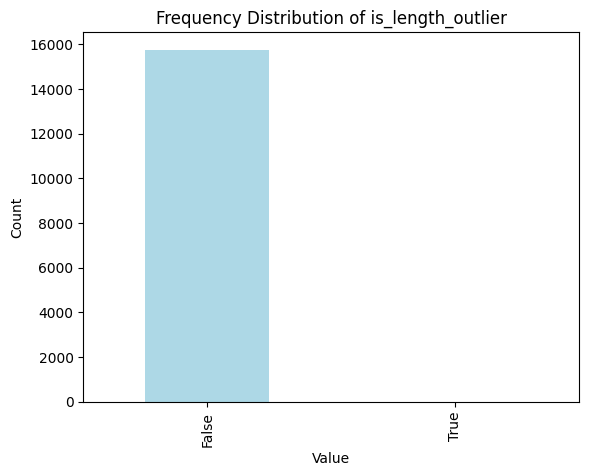

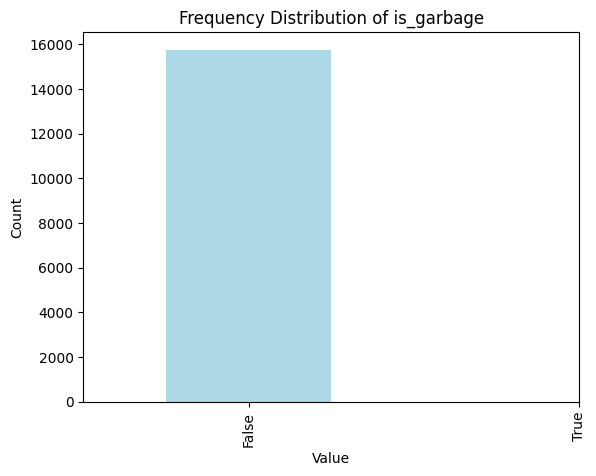

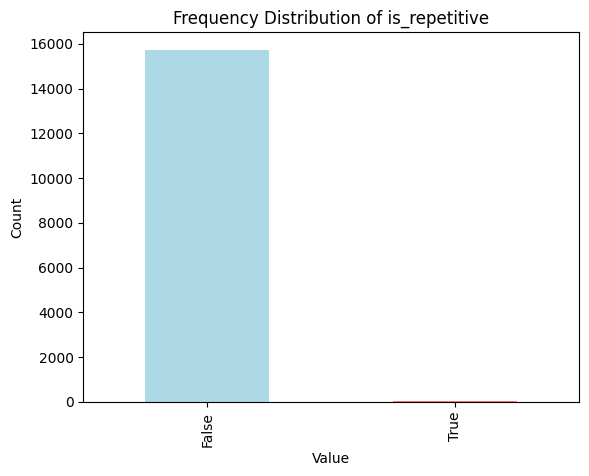

In [ ]:
# Function to plot frequency distribution for a given column
def plot_frequency_distribution(df, column_name):
    df[column_name].value_counts().plot(kind='bar', color=['lightblue', 'salmon'])
    plt.title(f'Frequency Distribution of {column_name}')
    plt.xlabel('Value')
    plt.ylabel('Count')
    plt.xticks(ticks=[0, 1], labels=['False', 'True'])
    plt.show()

# Plotting for each specified column
plot_frequency_distribution(dq_check, 'is_length_outlier')
plot_frequency_distribution(dq_check, 'is_garbage')
plot_frequency_distribution(dq_check, 'is_repetitive')

## ***6. Export Files***

In [ ]:
data.to_csv('tweets_data.csv', index=False)
files.download('tweets_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
texts.to_csv('tweets_texts.csv', index=False)
files.download('tweets_texts.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## ***7. Import Files***
Please download the datasets ***texts*** and ***Data*** from teams.


*   We will use texts for : sarcasm detection --> sarcasm interpretation --> KPI calculation.
*   We will use Data for : KPI Calculation part.





In [ ]:
# Upload file from local machine
uploaded = files.upload()

# Access the file by name from the uploaded dictionary
texts = pd.read_csv(io.StringIO(uploaded['tweets_texts.csv'].decode('utf-8')))
texts.head()

Saving tweets_texts.csv to tweets_texts.csv


,tweet_id,text
0,acd7673f-e621-5f1a-d662-df278964a6ea,the thameslink core between london st pancras ...
1,5b92aba8-4b05-6c63-8485-e9c870742137,loving the complaint about people having to wa...
2,0a799c07-8b76-17ba-b840-e538d51e832d,.and yet you have no toilets on some of your t...
3,8b4d2a34-c4f0-0e19-4055-dfe4af5f0e14,"you have no toilets on some of your trains, li..."
4,1fd08862-d8c7-0682-6b11-2603fba22d94,all the daft cared about was money and backsid...


## **8. Data Modelling Part A : Sarcasm Detection**

# **8.1 Model 1 : cardiffnlp/twitter-roberta-base-irony**
This model is based on RoBERTa, a robustly optimized variant of the BERT architecture. It uses transformers for natural language processing tasks.The tokenizer associated with the model uses a Byte Pair Encoding (BPE) tokenizer optimized for the specific language nuances of tweets, such as hashtags, mentions, and emojis. This model is well-suited for detecting ironic statements in social media text, especially tweets. It accounts for the informal and contextually rich nature of Twitter data.

In [ ]:
texts_bckup = texts.copy()
max_char_length = texts['text'].apply(len).max()
print("Maximum character length of tweets:", max_char_length)

Maximum character length of tweets: 480


In [ ]:
def predict_sarcasm(txt):
    inputs = tokenizer(txt, return_tensors="pt", truncation=True, padding=True, max_length=481)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    sarcasm_prob = probabilities[0][1].item()  # Probability of being sarcastic
    return sarcasm_prob

# Apply sarcasm prediction to each tweet
texts['sarcasm_score'] = texts['text'].apply(predict_sarcasm)
texts['sarcastic'] = texts['sarcasm_score'].apply(lambda x: 1 if x > 0.5 else 0)

# Select relevant columns for output
output_df = texts[['tweet_id', 'text', 'sarcasm_score', 'sarcastic']]

<ipython-input-51-2577012b177a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  texts['sarcasm_score'] = texts['text'].apply(predict_sarcasm)
<ipython-input-51-2577012b177a>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  texts['sarcastic'] = texts['sarcasm_score'].apply(lambda x: 1 if x > 0.5 else 0)


In [ ]:
output_df

,tweet_id,text,sarcasm_score,sarcastic
0,acd7673f-e621-5f1a-d662-df278964a6ea,the thameslink core between london st pancras ...,0.340264,0
1,5b92aba8-4b05-6c63-8485-e9c870742137,loving the complaint about people having to wa...,0.807071,1
2,0a799c07-8b76-17ba-b840-e538d51e832d,.and yet you have no toilets on some of your t...,0.541554,1
3,8b4d2a34-c4f0-0e19-4055-dfe4af5f0e14,"you have no toilets on some of your trains, li...",0.320328,0
4,1fd08862-d8c7-0682-6b11-2603fba22d94,all the daft cared about was money and backsid...,0.616181,1
...,...,...,...,...
15744,6f429a04-5817-f054-24d0-a9f20fddeb25,at st. alban's city has the pis screen firmwar...,0.357915,0
15745,b47948df-1732-7021-ee77-238f839a2ea0,haha oh man the audio corruption on is quite e...,0.935341,1
15746,bcb3a01a-e58c-e082-3111-10fa77d1a9f7,sweetis there a plug to charge my phone?,0.030832,0
15747,f440c7e6-9e2d-31c4-3626-b9d8288cbbe3,now there are far fewer commuters having to st...,0.206223,0


In [ ]:
from matplotlib import pyplot as plt
output_df['sarcastic'].plot(kind='hist', bins=20, title='sarcastic')
plt.gca().spines[['top', 'right',]].set_visible(False)

NameError: name 'output_df' is not defined

In [ ]:
flag_counts = output_df['sarcastic'].value_counts()
print(flag_counts)

sarcastic
0    13181
1     2568
Name: count, dtype: int64


# **8.2 Model 2 - T5-base Fine-Tuned for Sarcasm Detection**

In [ ]:
# Function to predict sarcasm score using T5 model
def predict_t5_sarcasm(text):
    inputs = t5_tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs = t5_model(**inputs)
    logits = outputs.logits
    probabilities = F.softmax(logits, dim=-1)
    sarcasm_score = probabilities[0][1].item()  # Probability of sarcastic class
    return sarcasm_score

In [ ]:
# Apply prediction to the DataFrame
#df['sarcasm_score_t5'] = df['text'].apply(predict_t5_sarcasm)
#df['sarcastic_t5'] = (df['sarcasm_score_t5'] > 0.5).astype(int)

# **8.2 Model 3 - BERTweet Base Fine-Tuned on SARC Dataset**

In [ ]:
# Function to predict sarcasm score using BERTweet model
def predict_bertweet_sarcasm(text):
    inputs = bertweet_tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs = bertweet_model(**inputs)
    logits = outputs.logits
    probabilities = F.softmax(logits, dim=-1)
    sarcasm_score = probabilities[0][1].item()  # Probability of sarcastic class
    return sarcasm_score

In [ ]:
# Apply prediction to the DataFrame
#df['sarcasm_score_bertweet'] = df['text'].apply(predict_bertweet_sarcasm)
#df['sarcastic_bertweet'] = (df['sarcasm_score_bertweet'] > 0.5).astype(int)

# **9. Evaluation**

To evaluate model performance using metrics like F1 score, ROC curve etc we need a labelled dataset. We have decided to use a sample dataset from Kaggle. We will test and evaluate the models with this sample dataset. In the scope of this project, we assume that the performance of this pre-trained model remains consistent across varied datasets.

## **9.1 Evaluation Model 1- with Evaluation Dataset Option 1**

Why multiple datasets? It is important to ensure that poor quality dataset selection should not be reason for poor model performance metrics.

In [ ]:
# Upload file from local machine
uploaded = files.upload()

# Access the file by name from the uploaded dictionary
sample_data = pd.read_csv(io.StringIO(uploaded['Sample_data.csv'].decode('utf-8')))
sample_data = sample_data.dropna()

sample_data.head()

Saving Sample_data.csv to Sample_data.csv


,Text,Label
0,@user new jersey not the big apple smh admin,1
1,the uk @user some 28bn of total wealth most of...,0
2,@user the feeling of a country being forced to...,0
3,@user @user @user i spend the entire summer by...,0
4,ill make a karma cometrueyeaahhh idgaf but at ...,1


9.1.1 Data Cleaning, handling, pre-processing


*   Apply the same steps on sample data as OUR dataset.
*   Clean the data, apply data quality check, remove the rows that fail the check.

*  Apply data preprocessing
*  Get y_pred from model, evaluate with Label column





In [ ]:
sample_data = sample_data.rename(columns={'Text': 'text'})

In [ ]:
sample_data.count()

,0
text,99891
Label,99891


In [ ]:
#Apply Quality checks
dq_check_eval = data_quality_check(sample_data)
dq_check_eval.count()

,0
text,99891
Label,99891
tweet_length,99891
is_length_outlier,99891
is_null,99891
is_garbage,99891
is_repetitive,99891


In [ ]:
flag_columns = ['is_length_outlier', 'is_null', 'is_garbage', 'is_repetitive']

# Drop rows where any flag column is True
sample_data = dq_check_eval[~dq_check_eval[flag_columns].any(axis=1)]
sample_data = sample_data.head(5000)
sample_data.count()

,0
text,5000
Label,5000
tweet_length,5000
is_length_outlier,5000
is_null,5000
is_garbage,5000
is_repetitive,5000


In [ ]:
sample_tweets = sample_data[['text']]
sample_label = sample_data[['Label']]

In [ ]:
sample_label

,Label
0,1
1,0
2,0
3,0
4,1
...,...
5094,0
5095,0
5096,0
5097,0


In [ ]:
# Apply preprocessing
sample_tweets['text'] = sample_tweets['text'].apply(preprocess_text)
sample_tweets

<ipython-input-22-31d5968fee27>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_tweets['text'] = sample_tweets['text'].apply(preprocess_text)


,text
0,new jersey not the big apple smh admin
1,the uk some 28bn of total wealth most of it ti...
2,the feeling of a country being forced to mourn
3,i spend the entire summer by changing my life ...
4,ill make a karma cometrueyeaahhh idgaf but at ...
...,...
5094,im still early in my use of it but i can see w...
5095,our democracy is code for the profoundly corru...
5096,freehand woodburning four fridays beginning se...
5097,im not leaving the best cos in virginia behind


In [ ]:
max_char_length = sample_tweets['text'].apply(len).max()
print("Maximum character length of tweets:", max_char_length)

Maximum character length of tweets: 278


In [ ]:
def predict_sarcasm(txt):
    inputs = tokenizer(txt, return_tensors="pt", truncation=True, padding=True, max_length=280)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    sarcasm_prob = probabilities[0][1].item()  # Probability of being sarcastic
    return sarcasm_prob

In [ ]:
# Apply sarcasm prediction to each tweet
sample_tweets['sarcasm_score'] = sample_tweets['text'].apply(predict_sarcasm)
sample_tweets['sarcastic'] = sample_tweets['sarcasm_score'].apply(lambda x: 1 if x > 0.5 else 0)

# Select relevant columns for output
Sample_output = sample_tweets[['text', 'sarcasm_score', 'sarcastic']]

In [ ]:
Sample_output

,text,sarcasm_score,sarcastic
0,new jersey not the big apple smh admin,0.257746,0
1,the uk some 28bn of total wealth most of it ti...,0.471012,0
2,the feeling of a country being forced to mourn,0.572473,1
3,i spend the entire summer by changing my life ...,0.840220,1
4,ill make a karma cometrueyeaahhh idgaf but at ...,0.048513,0
...,...,...,...
5094,im still early in my use of it but i can see w...,0.063696,0
5095,our democracy is code for the profoundly corru...,0.849363,1
5096,freehand woodburning four fridays beginning se...,0.048866,0
5097,im not leaving the best cos in virginia behind,0.118967,0


**9.1.2 Evaluation Function**

    Evaluate a model's performance and visualize ROC Curve, Confusion Matrix, and AUC.
    
    Outputs:
    - Classification Report, Confusion Matrix, ROC Curve, and AUC score.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(y_true, y_pred, model_name="Model"):

    # Classification Report
    print(f"--- {model_name} Evaluation ---")
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['Not Sarcastic', 'Sarcastic']))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    print(f"AUC Score: {roc_auc:.4f}")

    # Visualization: Confusion Matrix and ROC Curve
    plt.figure(figsize=(12, 5))

    # Subplot 1: Confusion Matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Sarcastic', 'Sarcastic'], yticklabels=['Not Sarcastic', 'Sarcastic'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

    # Subplot 2: ROC Curve
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
    plt.title(f'{model_name} - ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")

    # Show plots
    plt.tight_layout()
    plt.show()

--- Model 1 Evaluation ---
Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.83      0.72      0.77      3934
    Sarcastic       0.31      0.47      0.38      1066

     accuracy                           0.67      5000
    macro avg       0.57      0.60      0.57      5000
 weighted avg       0.72      0.67      0.69      5000

AUC Score: 0.5955


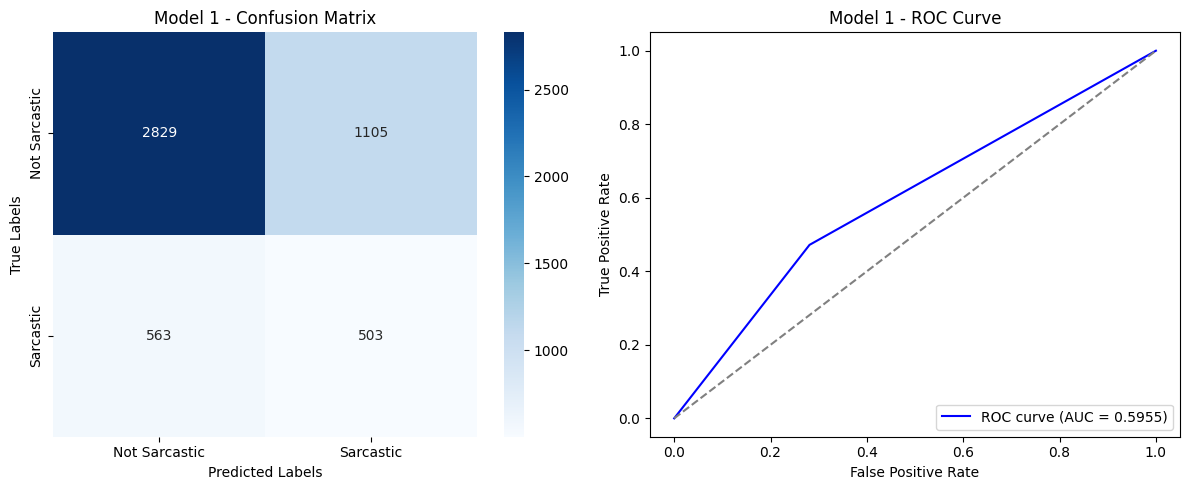

In [ ]:
evaluate_model(sample_label['Label'], Sample_output['sarcastic'], model_name="Model 1")


## **9.1 Evaluation Model 1- with Evaluation Dataset Option 2**
Confirming that the poor performance of data is not due to poor data qality

In [ ]:
from google.colab import files
import pandas as pd
# Upload file from local machine
uploaded = files.upload()

# Access the file by name from the uploaded dictionary
test_data= pd.read_csv('mytest.csv')
test_data.head()

Saving mytest.csv to mytest.csv


,text,label
0,I love finding out who your true friends are. ...,0
1,USER :/ bye,0
2,USER I absolutely love Kanye's voice USER,0
3,We're hiring a new Kiosk Supervisor! Think you...,0
4,Every time I see Dave Grohl with his long hipp...,0


**9.2.1 Data Cleaning**

In [ ]:
dq_check_eval = data_quality_check(test_data)
flag_columns = ['is_length_outlier', 'is_null', 'is_garbage', 'is_repetitive']

# Drop rows where any flag column is True
test_data = dq_check_eval[~dq_check_eval[flag_columns].any(axis=1)]

sample_tweets = test_data[['text']]
sample_label = test_data[['label']]

# Apply preprocessing
sample_tweets['text'] = sample_tweets['text'].apply(preprocess_text)

max_char_length = sample_tweets['text'].apply(len).max()
print("Maximum character length of tweets:", max_char_length)

Maximum character length of tweets: 144


<ipython-input-18-49c071f28463>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_tweets['text'] = sample_tweets['text'].apply(preprocess_text)


**9.2.2 Get y_pred from Model**

In [ ]:
# Apply sarcasm prediction to each tweet
sample_tweets['sarcasm_score'] = sample_tweets['text'].apply(predict_sarcasm)
sample_tweets['sarcastic'] = sample_tweets['sarcasm_score'].apply(lambda x: 1 if x > 0.5 else 0)

# Select relevant columns for output
res = sample_tweets[['text', 'sarcasm_score', 'sarcastic']]

<ipython-input-23-d7a22a6a2a60>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_tweets['sarcasm_score'] = sample_tweets['text'].apply(predict_sarcasm)
<ipython-input-23-d7a22a6a2a60>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_tweets['sarcastic'] = sample_tweets['sarcasm_score'].apply(lambda x: 1 if x > 0.5 else 0)


**9.2.3 Y-label vs Y-pred**

--- Model 1 Evaluation ---
Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.98      0.66      0.79       884
    Sarcastic       0.75      0.98      0.85       900

     accuracy                           0.82      1784
    macro avg       0.86      0.82      0.82      1784
 weighted avg       0.86      0.82      0.82      1784

AUC Score: 0.8231


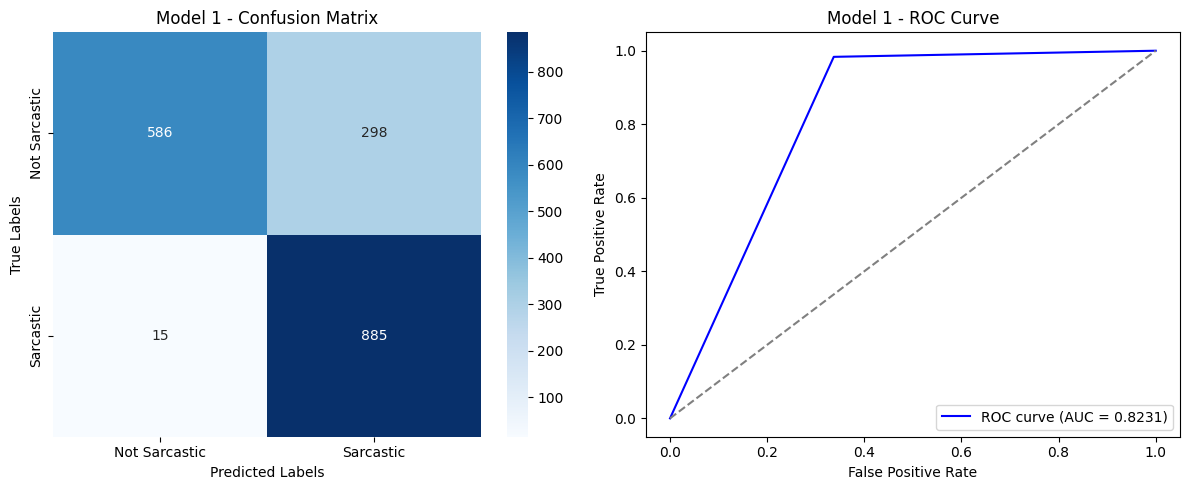

In [ ]:
evaluate_model(sample_label['label'], res['sarcastic'], model_name="Model 1")

## **9.2 Evaluation Model 2**


In [ ]:
tweets = test_data[['text']]
label = test_data[['label']]
# Apply prediction to the DataFrame
tweets['sarcasm_score'] = tweets['text'].apply(predict_t5_sarcasm)
tweets['sarcastic'] = (tweets['sarcasm_score'] > 0.5).astype(int)
tweets

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
<ipython-input-31-22b59862ab31>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['sarcasm_score'] = tweets['text'].apply(predict_t5_sarcasm)
<ipython-input-31-22b59862ab31>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['sarcastic'] = (tweets['sarcasm_score']

,text,sarcasm_score,sarcastic
0,I love finding out who your true friends are. ...,0.354310,0
1,USER :/ bye,0.449714,0
2,USER I absolutely love Kanye's voice USER,0.335078,0
3,We're hiring a new Kiosk Supervisor! Think you...,0.373477,0
4,Every time I see Dave Grohl with his long hipp...,0.354351,0
...,...,...,...
1795,i just love having unlimited texting with nobo...,0.310420,0
1796,just love getting free condoms at school #day ...,0.434011,0
1797,i love hitting red lights when u need to be so...,0.339150,0
1798,i love being sick when its a {number} day weekend,0.294264,0


--- Model 2 Evaluation ---
Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.50      1.00      0.66       884
    Sarcastic       0.00      0.00      0.00       900

     accuracy                           0.50      1784
    macro avg       0.25      0.50      0.33      1784
 weighted avg       0.25      0.50      0.33      1784

AUC Score: 0.5000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


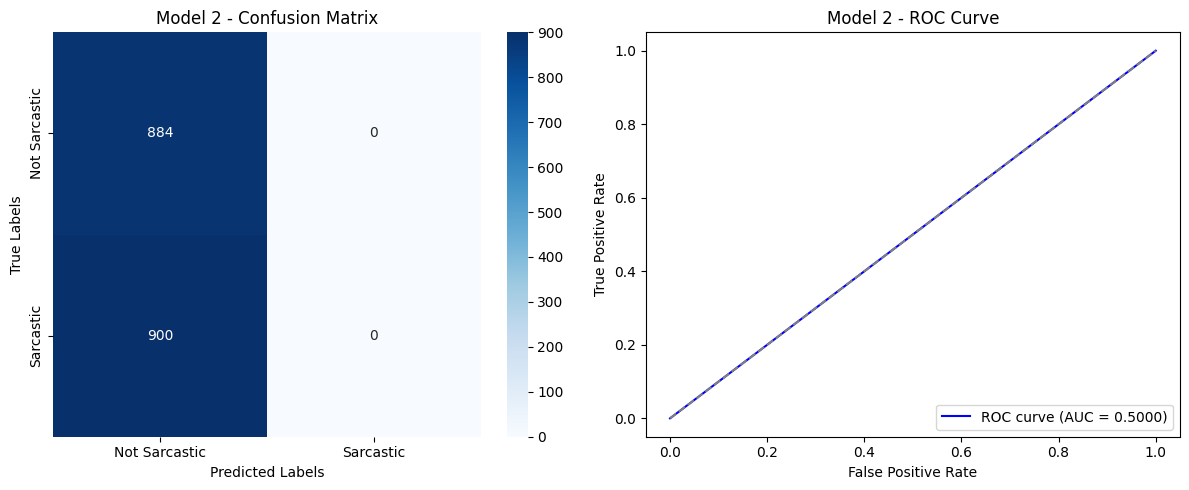

In [ ]:
evaluate_model(label['label'], tweets['sarcastic'], model_name="Model 2")

## **9.3 Evaluation Model 3**

In [ ]:
tweets_check = test_data[['text']]
label_check = test_data[['label']]

# Apply prediction to the DataFrame
tweets_check['sarcasm_score'] = tweets_check['text'].apply(predict_bertweet_sarcasm)
tweets_check['sarcastic'] = (tweets_check['sarcasm_score'] > 0.5).astype(int)

<ipython-input-35-0d22e84bb97e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_check['sarcasm_score'] = tweets_check['text'].apply(predict_bertweet_sarcasm)
<ipython-input-35-0d22e84bb97e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_check['sarcastic'] = (tweets_check['sarcasm_score'] > 0.5).astype(int)


--- Model 3 Evaluation ---
Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.89      0.68      0.77       884
    Sarcastic       0.75      0.92      0.82       900

     accuracy                           0.80      1784
    macro avg       0.82      0.80      0.80      1784
 weighted avg       0.82      0.80      0.80      1784

AUC Score: 0.7999


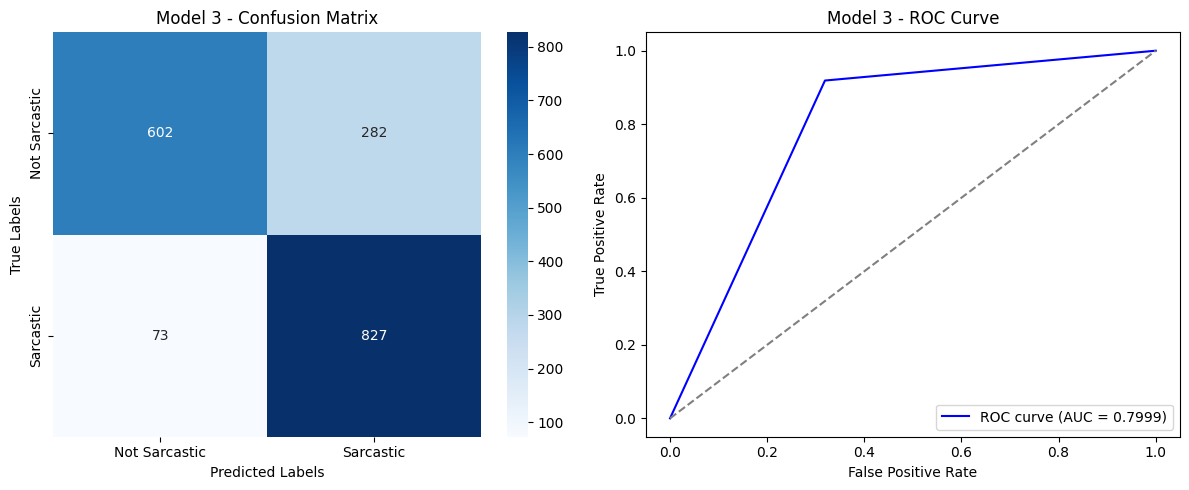

In [ ]:
evaluate_model(label_check['label'], tweets_check['sarcastic'], model_name="Model 3")